<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/Ensemble_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Descriptions

In [1]:
!rm -r airbnb_price

rm: cannot remove 'airbnb_price': No such file or directory


In [2]:
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 1134, done.
remote: Counting objects: 100% (1134/1134), done.
remote: Compressing objects: 100% (1073/1073), done.
remote: Total 1134 (delta 675), reused 304 (delta 55), pack-reused 0
Receiving objects: 100% (1134/1134), 9.90 MiB | 8.60 MiB/s, done.
Resolving deltas: 100% (675/675), done.


In [3]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
sys.path.append("/content/airbnb_price/models")
from ensemble_model import EnsembleModel2, EnsembleDataset2
import train_ensemble2 as train
import general_utils as ut
device = ut.get_device()
!mkdir -p /content/checkpoints/

/content/airbnb_price


/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


cuda available: False ; cudnn available: True ; num devices: 0
Using device cpu


In [4]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import json

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [481]:
desc = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/embeddings/descriptions.pickle")
rev = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/embeddings/reviews.pickle")
thumb = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/embeddings/thumbnails.pickle")
features = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/data1/listings_embeddedcats.pickle")
with open("/content/drive/MyDrive/Colab/airbnb/data/data1/catdict.json", "r") as f:
    catlist = json.load(f)

In [482]:
# if you want to set desc, rev and thumb to zero for performance comparison, run this chunk

# for i in range(len(desc)):
#     desc.iloc[i] = [0 for i in range(len(desc.iloc[0]))]

# for i in range(len(rev)):
#     rev.iloc[i] = [0 for i in range(len(rev.iloc[0]))]

# for i in range(len(thumb)):
#     thumb.iloc[i] = [0 for i in range(len(thumb.iloc[0]))]

In [483]:
logprice = features["log_price"]

In [484]:
selected_features = np.load("/content/drive/MyDrive/Colab/airbnb/data/feature_selection/selected_features2.npy", allow_pickle=True)
selected_features = (set(selected_features) & set(features.columns)) | set(['neighbourhood_cleansed', 'property_type', 'room_type', 'lang'])
features = features[selected_features]

In [485]:
desc = pd.DataFrame(desc)
thumb = pd.DataFrame(thumb)
rev = pd.DataFrame(rev)
logprice = pd.DataFrame(logprice)

In [486]:
data = pd.concat([thumb, desc, rev, features, logprice], axis=1)

# define which of the (possibly 7) data columns are treated as categories

In [487]:
# choose to exclude some columns from the cat_cols
cat_cols_regular = ['neighbourhood_cleansed', 
                    'property_type', 
                    'room_type', 
                    'lang', 
                    "availability_30", 
                    "accommodates", 
                    "bedrooms"]

cat_cols_exclude = [#'neighbourhood_cleansed', 
                    #'property_type', 
                    #'room_type', 
                    #'lang', 
                    #"availability_30", 
                    "accommodates", 
                    "bedrooms"
                    ]


cat_cols = cat_cols_regular.copy()
for x in cat_cols_exclude:
    cat_cols.remove(x)

rm_list = []
for i, col in enumerate(cat_cols_regular):
    if col in set(cat_cols_exclude):
        rm_list.append(i)

for i in rm_list[::-1]:
    del catlist[i]

to_replace = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/data1/listings_workfile.pickle")

if "neighbourhood_cleansed" in cat_cols_exclude:
    cat_cols_exclude.remove("neighbourhood_cleansed")
    data.loc[:, "neighbourhood_cleansed_Simmering"] = to_replace["neighbourhood_cleansed_Simmering"]
    data.loc[:, "neighbourhood_cleansed_Brigittenau"] = to_replace["neighbourhood_cleansed_Brigittenau"]
    data.loc[:, "neighbourhood_cleansed_Ottakring"] =  to_replace["neighbourhood_cleansed_Ottakring"]
    data.loc[:, "neighbourhood_cleansed_W\x8ahring"] =  to_replace["neighbourhood_cleansed_W\x8ahring"]
    data.loc[:, "neighbourhood_cleansed_Wieden"] =  to_replace["neighbourhood_cleansed_Wieden"]
    data.loc[:, "neighbourhood_cleansed_Hietzing"] =  to_replace["neighbourhood_cleansed_Hietzing"]
    data.loc[:, "neighbourhood_cleansed_Innere Stadt"] =  to_replace["neighbourhood_cleansed_Innere Stadt"]
    data = data.drop("neighbourhood_cleansed", axis=1)

if "property_type" in cat_cols_exclude:
    cat_cols_exclude.remove("property_type")
    data.loc[:, "property_type_shared_room"] =  to_replace["property_type_shared_room"]
    data.loc[:, "property_type_private_room"] =  to_replace["property_type_private_room"]
    data = data.drop("property_type", axis=1)

if "room_type" in cat_cols_exclude:
    cat_cols_exclude.remove("room_type")
    data.loc[:, "room_Private room"] =  to_replace["room_Private room"]
    data.loc[:, "room_Shared room"] =  to_replace["room_Shared room"]   
    data = data.drop("room_type", axis=1)

if "lang" in cat_cols_exclude:
    cat_cols_exclude.remove("lang")
    data = data.drop("lang", axis=1)

data.loc[:, cat_cols_exclude] = to_replace[cat_cols_exclude]

In [488]:
train_ids, val_ids, test_ids = ut.train_val_test_split(data.index)
traindf, valdf = data.loc[train_ids], data.loc[val_ids]

## Create DataLoader

In [489]:
# TODO
# create dataloaders
trainset = EnsembleDataset2(traindf, ["thumbnails"], ["descriptions"], ["reviews"], cat_cols, ["log_price"])
valset = EnsembleDataset2(valdf, ["thumbnails"], ["descriptions"], ["reviews"], cat_cols, ["log_price"])

b = 128
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)


#Training


In [490]:
no_of_thumb = 100
no_of_desc = 100
no_of_rev = 100
no_of_cont = len(traindf.columns) - 3 - 1 - len(catlist)  # -3 for thumb, desc and rev, -1 for price, last term to subtract cat cols
cat_emb_dims = [(len(x), 16) for x in catlist]
lin_layer_sizes = [512, 512, 512, 512, 512, 512]

In [ ]:
model = EnsembleModel2(no_of_thumb=no_of_thumb, no_of_desc=no_of_desc, no_of_rev=no_of_rev, no_of_cont=no_of_cont,
                       cat_emb_dims=cat_emb_dims, lin_layer_sizes=lin_layer_sizes, thumb_dropout=0.5, desc_dropout=0.5,
                       rev_dropout=0.5, cont_dropout=0, cat_dropout=0, linear_layer_dropout=[0, 0, 0], bn_layers=False)
model = model.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.1 ** (epoch // 15), last_epoch=- 1, verbose=True)
result = train.run_training(model, optimizer, loss_fn, device, 200, trainloader, 
                            valloader, verbose=True, ntrain=500, nval=200, scheduler=scheduler)

# Evaluation of final model

In [ ]:
# plot train and test
train_losses, val_losses, train_rmse, val_rmse = result
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='linear')
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='log')

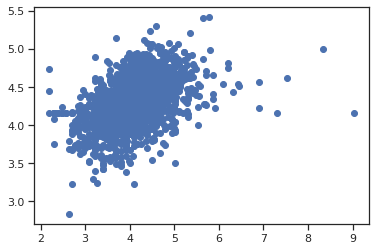

(0.44774102953267314, 4.025649390032662e-85)

In [ ]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt

ys = []
ypreds = []

with torch.no_grad():
    model = model.eval()

    for ids, labels, masks in valloader:
        ids, masks = ids.to(device), masks.to(device)
        y_pred = model1(ids, masks)[0]
        y_pred = list(y_pred.detach().cpu())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)


plt.scatter(ys, ypreds)
plt.show()
pearsonr(ys, ypreds)

In [ ]:

path ="/content/checkpoints/train_loss.npy"
np.save(path, train_losses)
path ="/content/checkpoints/val_loss.npy"
np.save(path, val_losses)

# do you want to save a checkpoint run this chunk
!mkdir -p /content/drive/MyDrive/Colab/airbnb/logs/ensemble/TEST
!cp -r /content/checkpoints/ /content/drive/MyDrive/Colab/airbnb/logs/ensemble/TEST

# Explainability categorical variables